# Analytical solutionn vs FEM solution for terazaghi 1D Consolidation

This section will explore and find the error between the time dependant PDE (Terazaghi PDE) when predicting consolidation settlement. 
------------------
Single Layer materials with the paramters for both displayed bellow:
- depth of 5m
- A pressure of 100 kpa applied 
- plotting over a year (with 100 time intervals)
- Cv = 2e-7 m^2/s (coefficient of consolidation)
- Mv = 5e-4 m^2/kN
-100 elements (101 nodes 1D)

Analytical Solution:
- N_terms = 100 (n terms for analytical solution)
- single drained analytical solution taken craig soil mechanics (asssumes a intial uniform stress distribution)

Assumptions and content:
- Terazaghi consolidation theory is 1D consolidation theory and this aims to plot and only considers consolidation in 1D (depth) and this single dimension 
- Intial conditions here is given as a uniform pressure through the ground (and not as 2:1 or Boussinesq) and example of how this is seen with depth is explored in another doccument) 


This will be used into getting the error of the FEM 1D Terazaghi, using the analytical as the reference point

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML

import matplotlib.dates as mdates


H = 5
num = 100
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 100
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

# n terms for analitical solution 
N_terms = 100

total_settlement = Mv*P*H


Numpy FEA solver

In [2]:

def create_local(Cv, Z):
    he = np.diff(Z)
    if np.round(he[0:1]) == np.round(he[1:2]):
        he = he[0:1]
        me = np.array([[2,1], [1,2]])
        Me = (he / 6) * me
        ke = np.array([[1,-1], [-1,1]])
        Ke = (Cv / he) * ke
        return Me, Ke 
    else:
        print("ERROR - 'he' not uniform")

def create_global(Matrix, num_nodes):
    num_nodes = int(num_nodes)
    Global_M = np.zeros((num_nodes,num_nodes))
    n = np.arange(num_nodes)
    for i in range(np.max(n)):
        i = int(i)
        Global_M[i : (i+2), i : (i+2)] += Matrix
    return Global_M

def boundary_conditions(LF, nodes):
    p = 0
    LF[:,p] = 0
    LF[p,:] = 0
    LF[p,p] = 1
    return LF

def solve_timestep(GMe, B, U0, time_step, nodes):
    p = 0
    GMe[:,p] = 0
    GMe[p,:] = 0
    GMe[p,p] = 1

    U0[p] = 0
    linear_form = GMe @ U0
    loop = np.arange(int(time_step))

    for i in loop:
        if i == 0: 
            pass
        elif i == 1:
            data = U0
            linear_form = GMe @ data
            linear_form[p] = 0
            Un = np.linalg.solve(B, linear_form)
            Un = np.array([Un])
            data = data.reshape(-1, 1).T
            data = np.concatenate((data,Un), axis=0)
        elif i > 1:
            Un = data[(i-1):i,:nodes]
            Un = Un.T
            linear_form = GMe @ Un 
            Un1 = np.linalg.solve(B, linear_form)
            Un1 = Un1.reshape(-1, 1).T
            data = np.concatenate((data,Un1), axis=0)
    return data
        
def interval_plotting():
    fig = plt.figure()
    axis = plt.axes(xlim = (0,4),
        ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    fig = plt.figure()
    
    axis = plt.axes(xlim = (0,4),
                ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    def init():
        line.set_data([],[])
        return line,

    def animate(i):
        x = np.linspace(0, 4, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x,y)
    return line,

# Setting up finite elements line and depths 
Z = -np.linspace(0, H, num = nodes)
U0 = P*np.ones(Z.shape, dtype=float)

# getting global matriccs and creating bilinear and linear form 
Me, Ke = create_local(Cv = Cv, Z=Z)
GMe, GKe = create_global(Me, nodes), create_global(Ke, nodes)
bilinear_form = (GMe) + (dt * GKe)

#apply boundary conditions and pore pressure solver 
B = boundary_conditions(bilinear_form, nodes)
data = solve_timestep(GMe, B, U0, time_step, nodes)

# Calculating local degree of consolidation
cdata = 1 - (data / P) 

fem_cdata = pd.DataFrame(cdata, columns = Z, index = np.arange(0, time_step))


Analytical solver

In [3]:
def terzaghi(H, Tx, time_step, nodes, Cv):
    Z = np.linspace(0, H, nodes)                 
    Cdata = np.zeros((time_step, nodes), dtype=float)
    T = np.linspace(0, Tx, time_step, dtype=float)

    for i in np.arange(nodes):
        z = Z[i]
        for j in np.arange(len(T)):
            t = T[j]
            S = 0.0
            for n in range(N_terms):
                m = (2 * n) + 1
                S += (1.0 / m) * np.sin((m * np.pi * z) / (2.0 * H)) * np.exp(-((m**2) * (np.pi**2) * Cv * t) / (4.0 * (H**2)))
            
            Cn = (4.0 / np.pi) * S
            Cdata[j, i] = Cn
    return Cdata

cdata = terzaghi(H, Tx, time_step, nodes, Cv)
cdata = 1 - cdata

# redefining due to plotting 
Z = -np.linspace(0, H, nodes)

Analytical_cdata = pd.DataFrame(cdata, columns = Z, index = np.arange(0, time_step))



Computing for Error 

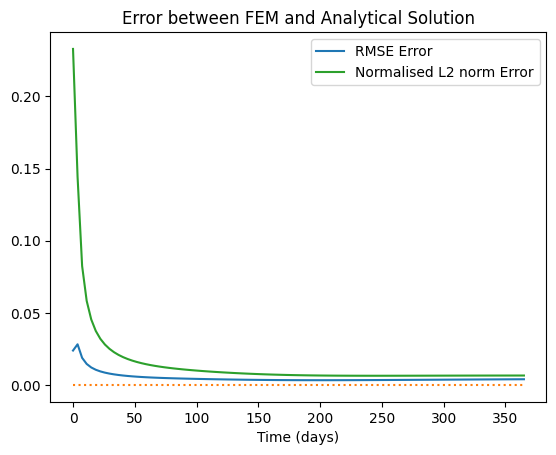

In [4]:
# assumes that the t and z for both data is identical in which it is 
error = fem_cdata - Analytical_cdata
#RMSE error per time step 
RMSE = np.sqrt((error**2).mean(axis = 1))
# Normalised L2 norm error 
num = (error**2).sum(axis = 1)
den = (Analytical_cdata**2).sum(axis = 1)
E_L2 = np.sqrt(num / (den+ 1e-12))
time = np.linspace(0, (Tx/(60*60*24)), time_step)

# plotting err
plt.figure()
plt.plot(time, RMSE, label = "RMSE Error")
plt.plot([0,np.max(time)],[0,0], linestyle ="dotted")  # Please change for capture of map
plt.plot(time, E_L2, label = "Normalised L2 norm Error")
plt.xlabel("Time (days)")
plt.legend()
plt.title("Error between FEM and Analytical Solution")
plt.show()


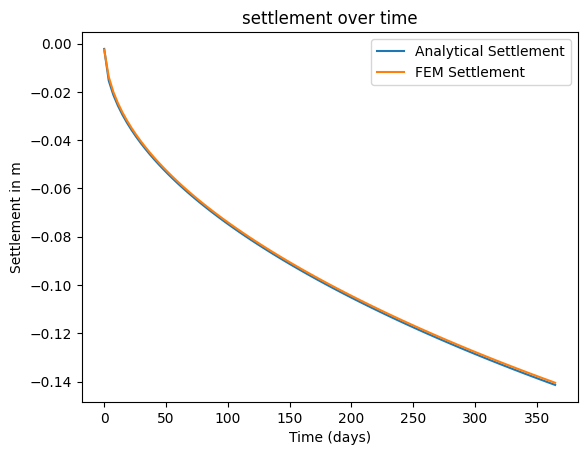

total settlement: 0.25 m
total consolidation settlement reach. 
analytical: 0.14141435862907437m 
FEM: 0.14051343990587623m 
actual total settlememt: 0.25 


In [5]:

# drawing settlement with time plotting 
total_settlement = Mv*P*H
total_settlement

analytical_settlement= Analytical_cdata.mean(axis=1)*total_settlement
fem_settlement = fem_cdata.mean(axis=1)*total_settlement

plt.figure()
plt.plot(time, -analytical_settlement, label="Analytical Settlement")
plt.plot(time, -fem_settlement, label="FEM Settlement")
plt.xlabel("Time (days)")
plt.ylabel("Settlement in m")
plt.legend()
plt.title("settlement over time")
plt.show()
print(f"total settlement: {total_settlement} m")

print(f"total consolidation settlement reach. \nanalytical: {np.max(analytical_settlement)}m \nFEM: {np.max(fem_settlement)}m \nactual total settlememt: {total_settlement} ")

A heat map as a reference of the consolidation over time using local degree of consolidation then computting to see the difference between the two to visually see the difference in plotting.

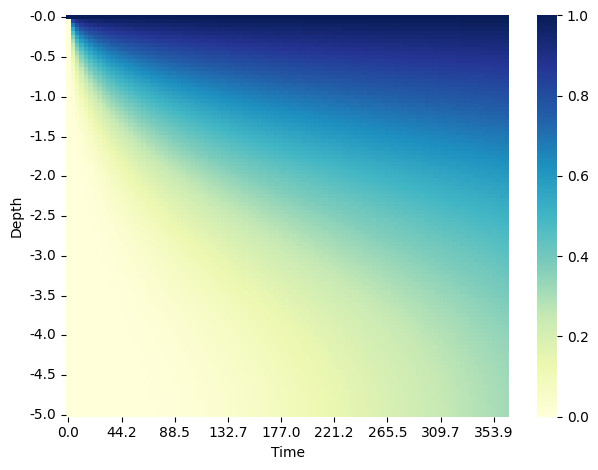

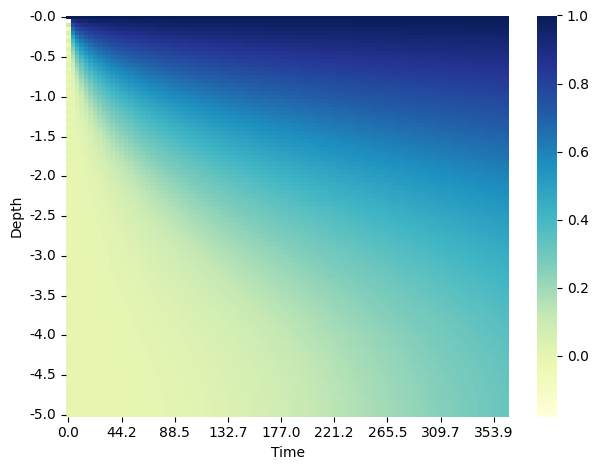

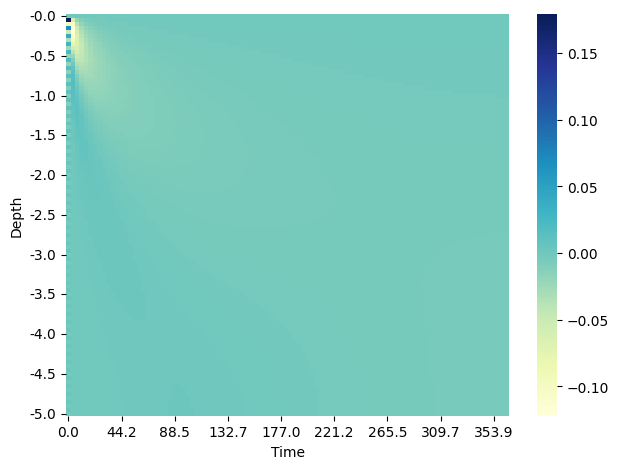

In [6]:
time = time
depth = Z
fem_cdata

kx = max(1, len(time)//8)    # ~8 labels across, auto
ky = max(1, len(depth)//10)  # ~10 labels down, auto 

ax = sns.heatmap(fem_cdata.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.show()



ax = sns.heatmap(Analytical_cdata.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.show()


ax = sns.heatmap(error.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.show()




